In [155]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resume-and-job-description/training_data.csv
/kaggle/input/resume-and-job-description/Resume.csv
/kaggle/input/resume-dataset/Resume/Resume.csv
/kaggle/input/resume-dataset/data/data/DESIGNER/22506245.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/13998435.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/67582956.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/34349255.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/26790545.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/12674307.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11807040.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/44145704.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/27497542.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11155153.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/17555081.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/41506705.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/54201930.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/2

In [156]:
#install all packages
!pip install tokenizer transformers scikit-learn pypdf==3.16.0 nltk pandarallel pandas==2.1.0 datasets #pyspark pyarrow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [157]:
#all imports
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import datasets
import transformers

In [158]:
#resume_data=pd.read_csv("kaggle resume dataset filepath") change it accordingly
resume_data=pd.read_csv("/kaggle/input/resume-dataset/Resume/Resume.csv")
resume_data=resume_data.drop(["Resume_html"],axis=1)

In [159]:
#getting all text from a pdf
from pypdf import PdfReader

def pdf_text(filePath:str)->str:
    reader = PdfReader(filePath)
    text=""
    for page in reader.pages:
        text+=page.extract_text()
    return text

In [160]:
#doing text cleaninig and tokenization
from nltk import pos_tag
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
import string
import re

puncuation=set(string.punctuation)
stop_words_english=set(stopwords.words("english"))
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    sentences = sent_tokenize(text)
    features = {'feature': ""}

    for sent in sentences:
        for criteria in ['skills', 'education']:
            if criteria in sent:
                words = word_tokenize(sent)
                words = [word for word in words if word not in stop_words_english]
                # POS tagger to identify and remove stop words and other irrelevant words
                tagged_words = pos_tag(words)
                filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
                features['feature'] += " ".join(filtered_words)

    return features

In [161]:
progress_bar=tqdm(range(len(resume_data)))
# extract text from csv and get the text from pdf
def process(df):
    #uncomment when using pdf_text function .. done to save time
    id=df['ID']
    category=df['Category'] 
    text=pdf_text(f"/kaggle/input/resume-dataset/data/data/{category}/{id}.pdf")
   # text=str(df["Resume_str"])
    features=preprocess_text(text)
    df['Feature']=features['feature']
    progress_bar.update(1)
    return df
      
#applying processing to resume_data
resume_data=resume_data.apply(process,axis=1)
resume_data=resume_data.drop(columns=['Resume_str'])



  0%|          | 0/2484 [00:00<?, ?it/s]

In [ ]:
#to avoid computing again and save time
#resume_data.to_csv("/path_to_save_processed_resume_data")
resume_data.to_csv("/kaggle/working/resume_data.csv",index=False)

In [162]:
#resume_data=pd.read_csv("/path_to_save_processed_resume_data")
resume_data=pd.read_csv("/kaggle/working/resume_data.csv")

In [163]:
resume_data.head()

,ID,Category,Feature
0,16852973,HR,hr administrator marketing associate hr admini...
1,22323967,HR,hr specialist hr operations summary media prof...
2,33176873,HR,hr director summary years experience recruitin...
3,27018550,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR,hr manager skill highlights hr skills hr depar...


<Axes: xlabel='Category'>

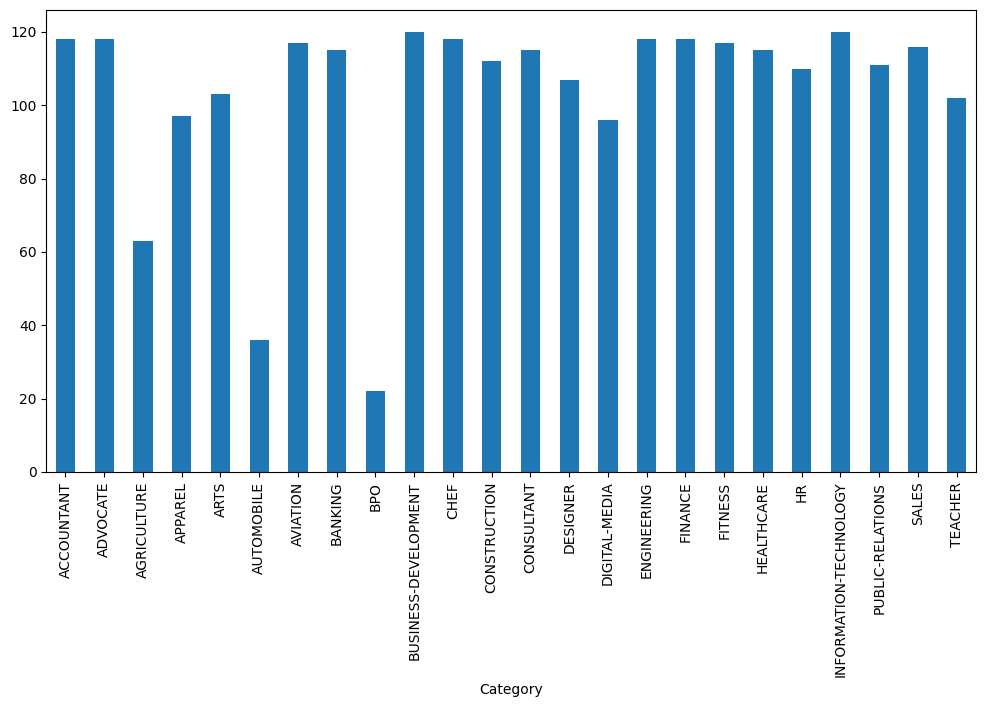

In [164]:
resume_data['Category'].value_counts().sort_index().plot(kind="bar",figsize=(12,6))

In [165]:
#getting job description
num_desc=15 #number of jod_description to fetch from job_description_data

#job_description=pd.read_csv("job_description_data.csv")
job_description=pd.read_csv("/kaggle/input/resume-and-job-description/training_data.csv")

#choosing 15 job description
job_description=job_description[["job_description","position_title"]][:num_desc]

In [ ]:
# processing the text of the job description
job_description['Features']=job_description['job_description'].apply(lambda x : preprocess_text(x)['feature'])


In [177]:
#choosing 15 job description
job_description=job_description[["job_description","position_title"]][:num_desc]
# processing the text of the job description
job_description['Features']=job_description['job_description'].apply(lambda x : preprocess_text(x)['feature'])


In [179]:
job_description.head()

,job_description,position_title,Features
0,minimum qualifications\nbachelors degree or eq...,Sales Specialist,minimum qualifications bachelors degree equiva...
1,description\nas an asc you will be highly infl...,Apple Solutions Consultant,description asc highly influential growing min...
2,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products,amazing time joining netflix continue transfor...
3,description\n\nweb designers looking to expand...,Web Designer,description web designers looking expand profe...
4,at trackfive weve got big goals were on a miss...,Web Developer,trackfive weve got big goals mission revolutio...


In [168]:
#using pytorch along with 🤗transformers...
from transformers import AutoModel, AutoTokenizer
import torch

device="cuda"if torch.cuda.is_available() else "cpu"

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

#putting model and tokenizer to gpu for faster processing 
model.to(device)


def get_embeddings(text):
    inputs = tokenizer(str(text), return_tensors="pt",truncation=True,padding=True).to(device)
    outputs = model(**inputs)
    #getting the embedding to cpu
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().to("cpu").numpy() 
    return embeddings


In [169]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd


# Calculate embeddings for all job descriptions and resumes
job_desc_embeddings = np.array([get_embeddings(desc) for desc in job_description['Features']])
resume_embeddings = np.array([get_embeddings(text) for text in resume_data['Feature']])



In [170]:
#sqeezing job embeding 
job_desc_embeddings=job_desc_embeddings.squeeze()
resume_embeddings=resume_embeddings.squeeze()
resume_embeddings.shape,job_desc_embeddings.shape

((2484, 768), (15, 768))

In [171]:
# Initialize a DataFrame to store the results
result_df = pd.DataFrame(columns=['jobId', 'resumeId', 'similarity', 'domainResume', 'domainDesc'])

# top k-resumes
k=5


In [172]:

# Iterate over job descriptions
for i, job_desc_emb in enumerate(job_desc_embeddings):
    job_desc_id = i
    job_title = job_description['position_title'].iloc[i]

    # Compute cosine similarities between the current job description and all resumes
    similarities = cosine_similarity([job_desc_emb], resume_embeddings )

    # Get the indices of the top-k most similar resumes
    top_k_indices = np.argsort(similarities[0])[::-1][:k]
   
    # Extract the relevant information and add it to the result DataFrame
    for j in top_k_indices:
        resume_id = resume_data['ID'].iloc[j]
        work_domain = resume_data['Category'].iloc[j]
        similarity_score = similarities[0][j]
        
        result_df.loc[i+j] = [job_desc_id, resume_id, similarity_score, work_domain,job_title ]
        

# Sort the results by similarity score (descending)
result_df = result_df.sort_values(by='similarity', ascending=False)



In [173]:
result_df.head()

,jobId,resumeId,similarity,domainResume,domainDesc
207,8,37664296,0.964158,DESIGNER,Web Designer
216,10,21283733,0.963997,DESIGNER,Web Developer
175,14,26790545,0.963242,DESIGNER,UI Web Designer
213,14,37664296,0.961985,DESIGNER,UI Web Designer
2370,10,79432080,0.961869,ARTS,Web Developer


In [174]:
result_group=result_df.groupby("jobId")
result_group

In [175]:
#example of group data
result_group.get_group(0)

,jobId,resumeId,similarity,domainResume,domainDesc
299,0,33381211,0.930880,INFORMATION-TECHNOLOGY,Sales Specialist
577,0,37521676,0.930776,BUSINESS-DEVELOPMENT,Sales Specialist
1235,0,17132168,0.930246,DIGITAL-MEDIA,Sales Specialist
1143,0,78016758,0.929602,CONSULTANT,Sales Specialist
1799,0,10624813,0.926079,ENGINEERING,Sales Specialist


In [176]:
for i in range(num_desc):
    print()
    print("jobId---cosineSimilarity---domainResume---domainDesc")
    print(result_group.get_group(i).values[0])
    print()


jobId---cosineSimilarity---domainResume---domainDesc
[0 33381211 0.9308804273605347 'INFORMATION-TECHNOLOGY' 'Sales Specialist']


jobId---cosineSimilarity---domainResume---domainDesc
[1 18905648 0.8815364241600037 'DIGITAL-MEDIA'
 'Apple Solutions Consultant']


jobId---cosineSimilarity---domainResume---domainDesc
[2 36758947 0.9561580419540405 'ARTS'
 'Licensing Coordinator - Consumer Products']


jobId---cosineSimilarity---domainResume---domainDesc
[3 46258701 0.9254276156425476 'HR' 'Web Designer']


jobId---cosineSimilarity---domainResume---domainDesc
[4 13727873 0.9483727812767029 'PUBLIC-RELATIONS' 'Web Developer']


jobId---cosineSimilarity---domainResume---domainDesc
[5 18905648 0.8790100812911987 'DIGITAL-MEDIA' 'Frontend Web Developer']


jobId---cosineSimilarity---domainResume---domainDesc
[6 38565119 0.9573699235916138 'DESIGNER' 'Remote Website Designer']


jobId---cosineSimilarity---domainResume---domainDesc
[7 12632728 0.5323570966720581 'BUSINESS-DEVELOPMENT' 'Web Des